In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
from scipy.stats import chi2, norm
from scipy.special import xlogy

In [4]:
from sklearn.metrics import precision_recall_curve, roc_curve
from kde_utils import kde_bw
from kde_utils import kde_process_data
from kde_utils import kde_make_transformers

In [5]:
X, y_true = make_classification(n_samples=1000, n_classes=2, random_state=1)

model = LogisticRegression(solver='lbfgs')
model.fit(X, y_true)
y_prob = model.predict_proba(X)[:, 1]

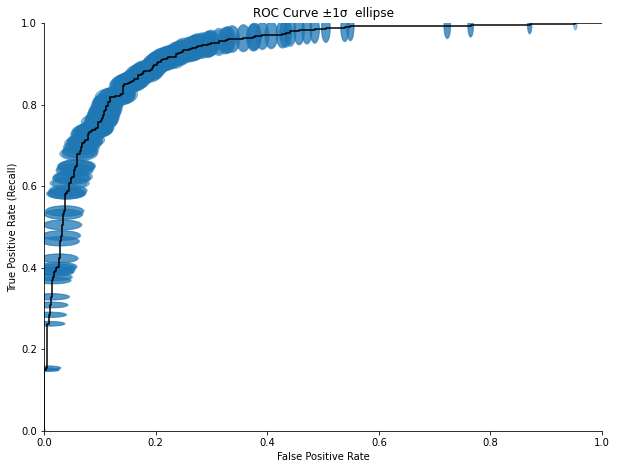

In [13]:

def phat(rec, prec, x_tp, x_fp, x_tn, x_fn):
    """Fit probability parameters of confusion matrix under the constraint of
    fixed recall and precision
    """
    n4 = x_tp + x_fp + x_tn + x_fn
    n3 = x_tp + x_fp + x_fn
    alpha = (1-prec)/prec + (1-rec)/rec + 1
    p_tp = (n3 / n4) * (1. / alpha)
    p_fn = ((1-rec)/rec) * p_tp
    p_fp = ((1-prec)/prec) * p_tp
    p_tn = 1. - p_fn - p_fp - p_tp
    # prevent negative values to due machine level noise
    if isinstance(p_tn, np.ndarray):
        p_tn[p_tn < 0] = 0
    elif isinstance(p_tn, float) and p_tn < 0:
        p_tn = 0.
    return p_tp, p_fp, p_tn, p_fn


def nll(rec, prec, x_tp, x_fp, x_tn, x_fn):
    """Return -2logp of multinomial distribution fixed at certain recall and precision

    Two steps:
    1. Fit with fixed recall and precision
    2. Fit with all probability parameters free

    Return the difference in -2 log L
    """
    # optimal fit of x
    n4 = x_tp + x_fp + x_tn + x_fn
    p_fn0 = x_fn / n4
    p_tp0 = x_tp / n4
    p_fp0 = x_fp / n4
    p_tn0 = x_tn / n4
    nll_minimum = -2 * xlogy(x_tp, p_tp0) - 2 * xlogy(x_fp, p_fp0) - 2 * xlogy(x_fn, p_fn0) - 2 * xlogy(x_tn, p_tn0)

    # fit of x constrained to recall and precision
    p_tp, p_fp, p_tn, p_fn = phat(rec, prec, x_tp, x_fp, x_tn, x_fn)
    nll_value = -2 * xlogy(x_tp, p_tp) - 2 * xlogy(x_fp, p_fp) - 2 * xlogy(x_fn, p_fn) - 2 * xlogy(x_tn, p_tn)

    # return the difference
    return nll_value - nll_minimum


def get_PRgrid(x_tp, x_fp, x_fn, nbins=100, epsilon=1e-4):
    """Make a rough estimate for the range of the precision-recall grid to scan
    """

    # epsilon to prevent division by zero at edge
    # Note: true values recall=100% or prec=100% can only hit boundary if fn=0 or fp=0
    # else clip max values of recall and precision
    max_rec_clip = 0 if x_fn == 0 else epsilon
    max_prec_clip = 0 if x_fp == 0 else epsilon

    rec = x_tp / (x_tp + x_fn)
    prec = x_tp / (x_tp + x_fp)

    # get rough estimates of sigma_rec and sigma_precision
    # for rec=0,1 the uncertainty formula gives zero, correct for this
    if rec == 0:
        rec_for_sigma = 1 / (x_tp + x_fn)
    elif rec == 1:
        rec_for_sigma = (x_tp + x_fn - 1) / (x_tp + x_fn)
    else:
        rec_for_sigma = rec
    # for prec=0,1 the uncertainty formula gives zero, correct for this
    if prec == 0:
        prec_for_sigma = 1 / (x_tp + x_fp)
    elif prec == 1:
        prec_for_sigma = (x_tp + x_fp - 1) / (x_tp + x_fp)
    else:
        prec_for_sigma = prec
    # rough estimates of sigma_rec and sigma_precision
    sigma_rec = np.sqrt((rec_for_sigma*(1-rec_for_sigma))/(x_tp + x_fn))
    sigma_prec = np.sqrt((prec_for_sigma*(1-prec_for_sigma))/(x_tp + x_fp))

    # ranges of P and R to scan
    rec_max = min(rec + 6 * sigma_rec, 1 - max_rec_clip)
    rec_min = max(rec - 7 * sigma_rec, epsilon)
    prec_max = min(prec + 6 * sigma_prec, 1 - max_prec_clip)
    prec_min = max(prec - 7 * sigma_prec, epsilon)

    # make PR grid to scan
    rx = np.linspace(rec_min, rec_max, nbins)
    py = np.linspace(prec_min, prec_max, nbins)
    RX, PY = np.meshgrid(rx, py)

    return RX, PY


def tail_uncertainty(y_true, y_prob, thresholds, FP, FN):
    # estimate the FP tail
    bin_entries, bin_means = kde_process_data(y_prob[y_true == 0], mirror_left=0, mirror_right=1)

    bandwidth = kde_bw(bin_means, bin_entries, n_adaptive=5, rho=0.15)

    fast_pdf, F, Finv, kde_norm = kde_make_transformers(bin_means, bin_entries, band_width=bandwidth, x_min=0, x_max=1)

    N0 = len(y_true[y_true == 0])

    FPf = (1. - F(thresholds)) * N0

    # replace zero FPs with estimates
    FP = FP.astype(float)
    for i, fb in enumerate(FP):
        if fb == 0:
            FP[i] = FPf[i]

    # estimate the FN tail
    bin_entries, bin_means = kde_process_data(y_prob[y_true == 1], mirror_left=0, mirror_right=1)

    bandwidth = kde_bw(bin_means, bin_entries, n_adaptive=5, rho=0.15)

    fast_pdf, F, Finv, kde_norm = kde_make_transformers(bin_means, bin_entries, band_width=bandwidth, x_min=0, x_max=1)

    N1 = len(y_true[y_true == 1])

    FNf = F(thresholds) * N1

    # replace zero FNs with estimates
    FN = FN.astype(float)
    for i, fn in enumerate(FN):
        if fn == 0:
            FN[i] = FNf[i]

    return FP, FN


def get_scaling_factor(norm_nstd):
    # Get the scale for 2 degrees of freedom confidence interval
    # We use chi2 because the equation of an ellipse is a sum of squared variable,
    # more details here https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
    # norm_nstd = 1  # number of standard deviation
    norm_pct = 2. * (norm.cdf(norm_nstd) - 0.5)
    chi2_quantile = chi2.ppf(norm_pct, 2)
    scale = np.sqrt(chi2_quantile)
    return scale


def get_radii_and_angle(var_precision, var_recall, covar_recall_precision):
    # Angle and lambdas
    # based on https://cookierobotics.com/007/ :
    a = var_recall  # cov[0][0]
    c = var_precision  # cov[1][1]
    b = covar_recall_precision  # cov[1][0]
    lambda1 = (a+c)/2 + np.sqrt(((a-c)/2)**2 + b**2)
    lambda2 = (a+c)/2 - np.sqrt(((a-c)/2)**2 + b**2)

    def calculate_theta(lambda1, a, b, c):
        if b == 0 and a >= c:
            return 0.
        elif b == 0 and a < c:
            return np.pi / 2.
        else:
            return np.arctan2(lambda1 - a, b)

    theta = np.vectorize(calculate_theta)(lambda1, a, b, c)
    angle = theta / np.pi * 180

    # Radii of the ellipse
    recall_r = np.sqrt(lambda1)
    precision_r = np.sqrt(lambda2)

    return recall_r, precision_r, angle


def get_confusion_matrix(y_true, y_prob, thresholds):
    N = len(y_true)

    # remark: computing them with metrics.confusion_matrix() takes too much time
    P = np.array([sum(y_true)] * len(thresholds))
    # we use ">= thr" like in precision_recall_curve():
    TP = np.array([((y_prob >= thr) & y_true).sum() for thr in thresholds])
    PP = np.array([(y_prob >= thr).sum() for thr in thresholds])
    FN = P - TP
    FP = PP - TP
    TN = N - TP - FP - FN

    return TP, FP, TN, FN


def get_roc_var_covar(y_true, y_prob, thresholds, tails=False):
    # Getting TP, FN, FP
    TP, FP, TN, FN = get_confusion_matrix(y_true, y_prob, thresholds)

    if tails:
        FP, FN = tail_uncertainty(y_true, y_prob, thresholds, FP, FN)

    # Variance
    # when FP or FN is zero, assume a downward fluctuation. For uncertainty band, set conservatively to 1 instead.
    def zero_to_one(x, value=1):
        xp = x.copy()  # .astype(float)
        xp[xp == 0] = value
        return xp

    var_TPR = (FN*TP) / (FN+TP)**3
    var_FPR = (FP*TN) / (FP+TN)**3


    return var_FPR, var_TPR, 0


def plot_ROC_curve_with_CI(y_true, y_prob, norm_nstd=1, tails=True, lim=1.0, method='contour'):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)

    # No need to add zero threshold (missing by default)
    #print(thresholds[:3]) # first value 1.999
    #print(fpr[:3])
    #print(tpr[:3])

    scale = get_scaling_factor(norm_nstd)

    # Plot precision-recall curve
    fig, ax = plt.subplots(figsize=(10, 7.5))

    # Plot first contours/ellipses
    if method == 'ellipse':
        var_FPR, var_TPR, covar_recall_precision = get_roc_var_covar(y_true, y_prob, thresholds, tails)

        FPR_r, TPR_r, angle = get_radii_and_angle(var_FPR, var_TPR, covar_recall_precision)

        # For each point in the precision-recall curve plot an ellipse
        for i, (r, p, r_r, p_r, a) in enumerate(zip(fpr, tpr, FPR_r, TPR_r, angle)):

            if (r == 1 or p == 1):  # tails
                color = 'lightblue'
            else:
                color = 'C0'

            # we multiply the radius by 2 because width and height are diameters
            ellipse = matplotlib.patches.Ellipse(
                (r, p), width=2*scale*r_r, height=2*scale*p_r, angle=a, alpha=0.50, color=color)  #, color=adjust_lightness(cmap(color_i), 1.5))

            ax.add_patch(ellipse)

    elif method == 'contour':
        TP, FP, TN, FN = get_confusion_matrix(y_true, y_prob, thresholds)
        # For each point in the precision-recall curve plot an ellipse
        for i, (r, p, x_tp, x_fp, x_tn, x_fn) in enumerate(zip(recall, precision, TP, FP, TN, FN)):
            if (r == 1 or p == 1):  # tails
                color = 'lightblue'
            else:
                color = 'C0'

            RX, PY = get_PRgrid(x_tp, x_fp, x_fn)
            chi2 = nll(RX, PY, x_tp, x_fp, x_tn, x_fn)
            CS = ax.contour(RX, PY, chi2, levels=[scale**2], alpha=0.50, colors=color)

    # Plot line after the contours/ellipses to see it well
    ax.plot(fpr, tpr, label='classifier', color='black')  # or adjust_lightness
    ax.set_xlim((0, lim))
    ax.set_ylim((0, lim))

    if lim > 1.0:
        # If limit bigger than 1, then we need white rectangle trick:
        rec1 = matplotlib.patches.Rectangle([0, 1.], lim, lim-1, ec="none", color='white')
        rec2 = matplotlib.patches.Rectangle([1, 0.], lim-1, lim, ec="none", color='white')
        ax.add_patch(rec1)
        ax.add_patch(rec2)
    else:
        # If limit is <=1.0 we don't need rectangle, but we need to hide the right and top spines
        # in order to see the curve at the border:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Recall)')
    ax.set_title(f'ROC Curve ±{norm_nstd}σ  {method}')
    # ax.legend(loc="lower left")

    return fig

plot_ROC_curve_with_CI(y_true, y_prob, method='ellipse', tails=False);

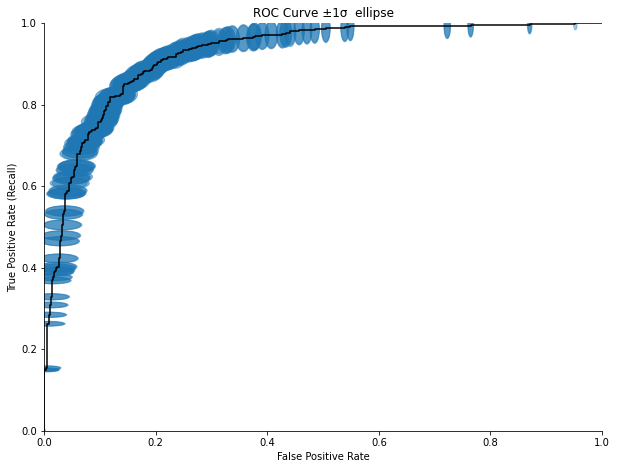

In [14]:
plot_ROC_curve_with_CI(y_true, y_prob, method='ellipse', tails=True);